<a href="https://colab.research.google.com/github/codingFerryman/crypto_market_hierarchy_structure/blob/main/src/30m_MST_per_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 20211010-20211017, 30m, MST per day

In [ ]:
import datetime
from pathlib import Path
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data, datestring_to_timestamp, get_golden_timestamps, my_fillna
import mplfinance as mpf
import datetime
import numpy as np
import seaborn as sns
import networkx as nx
import planarity

plt.rcParams.update({'font.size': 22})

In [ ]:
stable_coins = ['UST','PAX','DAI', 'MIM','TSD','UDC','EOSDT','XCH','EUS','XAUT']

In [ ]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['30m']
time_ranges = []
for i in range(7):
    time_ranges.append(("2021-10-1"+str(i), "2021-10-1"+str(i+1)))
timestamp_ranges = [tuple(map(datestring_to_timestamp, tup)) for tup in time_ranges]
coins_pass_check_1 = {}

for interval in intervals:
    coins_pass_check_1[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        #if check_integrity(*time_ranges[0], file_path) is not None:
        coins_pass_check_1[interval].append(coin_code)

In [ ]:
def check_integrity_score_and_load_data(coins_pass_pre_check, score_threshold, check_intervals=['30m']):
    _coins_integrity = {}
    _coins_in_use = {}
    for _interval in check_intervals:
        _coins_integrity[_interval] = {}
        _coins_in_use[_interval] = {}
        _data_interval_dir = Path(data_dir, _interval)
        for i in time_ranges: 
            _coins_integrity[_interval][i] = {}
            _coins_in_use[_interval][i] = {}
            _coins_in_use[_interval][i]['data'] = {}
            _coins_in_use[_interval][i]['coin_list'] = None
            _temp_coins_in_use = []
            _temp_coins_in_use_list = []
            for _coin in coins_pass_pre_check['30m']:
                _file_path = Path(_data_interval_dir, f"{_coin}_USD_{_interval}.csv")                
                _c_df = load_data(i[0], i[1], _file_path, fill_na=True)
                if len(_c_df):
                    _coins_integrity[_interval][i][_coin] = len(_c_df[_c_df.is_fill == False]) / len(_c_df)
                    if _coins_integrity[_interval][i][_coin] >= score_threshold:
                        _temp_coins_in_use.append(_c_df)
                        _temp_coins_in_use_list.append(_coin)
                else: 
                    _coins_integrity[_interval][i][_coin] = None
            _coins_in_use[_interval][i]['data'] = pd.concat(_temp_coins_in_use)
            _coins_in_use[_interval][i]['coin_list'] = _temp_coins_in_use_list                            
    return _coins_integrity, _coins_in_use

In [ ]:
integrity_score, coins_in_use = check_integrity_score_and_load_data(coins_pass_check_1, 0.4)

In [ ]:
def close_pcr_cm(df, coin_list):
    _tmp_df_pcr_list = []
    for tick in coin_list:
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()['close'].rename(f'{tick}')        
        _tmp_df_pcr = _tmp_df.pct_change().fillna(0)
        _tmp_df_pcr_list.append(_tmp_df_pcr)
    _tmp_pcr_df = pd.concat(_tmp_df_pcr_list, axis=1)
    _tmp_pcr_df_cm = _tmp_pcr_df.corr(method='pearson')
    return _tmp_pcr_df_cm

In [ ]:
# correlation matrix of percentage change of returns
cm_pcr = {}
for i in time_ranges:
    df = coins_in_use['30m'][i]['data']
    coin_list = coins_in_use['30m'][i]['coin_list']
    cm_pcr[i] = close_pcr_cm(df, coin_list)    

In [ ]:
cm_pcr[time_ranges[0]]

,BTT,FIL,OCEAN,SUN,KSM,DORA,DOT,EOS,EUT,KNC,...,DOGE,BTSE,UOS,ZCN,XMR,ICE,1INCH,LRC,UNI,XRD
BTT,1.000000,0.590602,0.493285,0.249690,0.349424,0.361250,0.541653,0.669239,0.153734,0.253665,...,0.486415,0.066952,0.404100,0.100396,0.535723,-0.010871,0.408957,0.598102,0.506966,0.170149
FIL,0.590602,1.000000,0.611052,0.532765,0.553641,0.503539,0.638949,0.820422,0.078010,0.491868,...,0.807864,0.136035,0.634084,0.129083,0.735966,0.171228,0.799707,0.736588,0.723849,0.214106
OCEAN,0.493285,0.611052,1.000000,0.277975,0.502939,0.305084,0.621684,0.588022,-0.114159,0.553685,...,0.584838,0.082541,0.295906,0.079425,0.494044,0.145111,0.442606,0.699892,0.474032,0.344781
SUN,0.249690,0.532765,0.277975,1.000000,0.376866,0.192989,0.338764,0.595236,0.012376,0.200129,...,0.487593,0.243593,0.317542,0.210441,0.533854,0.274901,0.700541,0.415275,0.456553,0.106074
KSM,0.349424,0.553641,0.502939,0.376866,1.000000,0.214505,0.700724,0.485427,-0.099276,0.281646,...,0.502130,-0.303222,0.308126,-0.047193,0.410626,0.027452,0.541155,0.517725,0.521707,0.155078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICE,-0.010871,0.171228,0.145111,0.274901,0.027452,-0.035911,0.168300,0.123022,-0.015911,0.360085,...,0.233798,0.248409,0.053556,0.137469,0.294130,1.000000,0.285379,0.045851,0.110702,0.142171
1INCH,0.408957,0.799707,0.442606,0.700541,0.541155,0.263945,0.572113,0.725125,0.016084,0.361550,...,0.716706,0.148652,0.498835,0.090459,0.732467,0.285379,1.000000,0.637820,0.782587,0.139222
LRC,0.598102,0.736588,0.699892,0.415275,0.517725,0.405965,0.618243,0.755825,0.031626,0.371049,...,0.685187,0.093695,0.450526,0.104278,0.753702,0.045851,0.637820,1.000000,0.694275,0.201078
UNI,0.506966,0.723849,0.474032,0.456553,0.521707,0.278260,0.599701,0.745411,-0.029858,0.411958,...,0.729953,0.112960,0.560955,0.004062,0.758653,0.110702,0.782587,0.694275,1.000000,0.150124


In [ ]:
def MST_from_cm_pcr(cmpcr): # cm_pcr[time_ranges[0]]
    
    def MST(corr_mat):
        _dist_mx = np.sqrt(2*(1-corr_mat))
        _G = nx.from_numpy_matrix(_dist_mx)
        _M = nx.minimum_spanning_tree(_G,weight='weight')
        return _M

    _MST = MST(cmpcr.to_numpy())
    _tickers_list = list(cmpcr.columns)
    _tickers = {i:list(cmpcr.columns)[i] for i in range(len(list(cmpcr.columns)))}  
    nx.set_node_attributes(_MST, values=_tickers, name='ticker')
    
    def topN(N, G):
        _degree = np.array([d for n, d in G.degree()])
        _top_indx = np.argsort(_degree)[-N:]
        _top_degree_ticker = [(G.nodes[i]['ticker'], G.degree(i)) for i in _top_indx[::-1]]
        print('nodes of the largest degrees: ', _top_degree_ticker)
        _node_top_degree_ticker = [_tickers_list.index(i[0]) for i in _top_degree_ticker]        
        return _top_degree_ticker, _node_top_degree_ticker
    _top_ticker, _node_top_ticker = topN(5, _MST)
    
    _node_stable_coins = [_tickers_list.index(i) for i in stable_coins if i in _tickers_list]
    print('nodes of stable coins: ', _node_stable_coins)    
    # other nodes of interest
    _node_BTC = _tickers_list.index('BTC')
    _BTC_degree = _MST.degree[_node_BTC]
    print('degree of BTC node: ', _BTC_degree)
    
    for i in range(len(_tickers_list)):
        if i in _node_stable_coins: _MST.nodes[i]['color'] = 'orange'  
        elif i in _node_top_ticker: _MST.nodes[i]['color'] = 'red'
        else: _MST.nodes[i]['color'] = 'lightblue'
            
    return _MST, _top_ticker, _BTC_degree

In [ ]:
M0, M0_top5, M0_BTC = MST_from_cm_pcr(cm_pcr[time_ranges[0]])

nodes of the largest degrees:  [('BAL', 11), ('TRX', 7), ('OXY', 5), ('BAND', 5), ('EOS', 5)]
nodes of stable coins:  [46, 49, 101]
degree of BTC node:  4


In [ ]:
M1, M1_top5, M1_BTC = MST_from_cm_pcr(cm_pcr[time_ranges[1]])

nodes of the largest degrees:  [('DOGE', 7), ('OCEAN', 5), ('1INCH', 5), ('NEO', 5), ('BAND', 5)]
nodes of stable coins:  [47, 50, 101]
degree of BTC node:  4


In [ ]:
M2, M2_top5, M2_BTC = MST_from_cm_pcr(cm_pcr[time_ranges[2]])

nodes of the largest degrees:  [('ZEC', 8), ('SUSHI', 7), ('BCHN', 7), ('NEO', 5), ('BAND', 5)]
nodes of stable coins:  [49, 52, 101]
degree of BTC node:  1


In [ ]:
def MST_plot(M, title, fign):
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    fig.suptitle(fign+'Minimal Spanning Tree of '+title, fontsize=14, y=0.92)
    pos = nx.spring_layout(M)
    # nx.set_node_attributes(M, values=tickers, name='ticker')
    nx.draw(M,pos=pos,with_labels=True,labels=tickers,
            node_size=20,font_size=10,edge_color='lightgray',
            node_color = [M.nodes[i]['color'] for i in M.nodes()],
            verticalalignment='bottom',alpha=1,ax=ax)

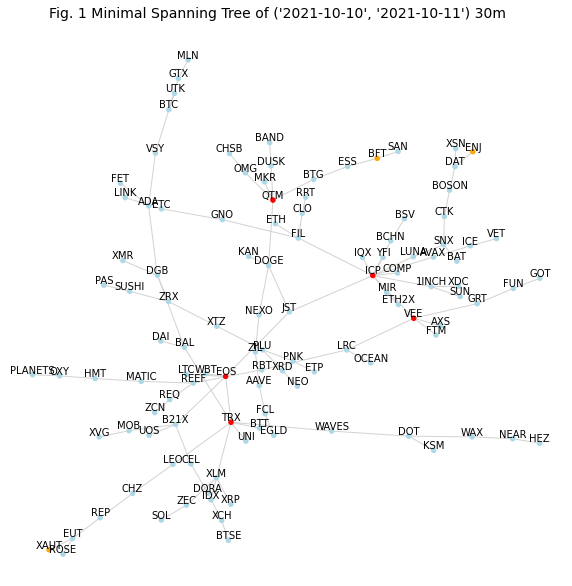

In [ ]:
MST_plot(M0, f'{time_ranges[0]} 30m', 'Fig. 1 ')

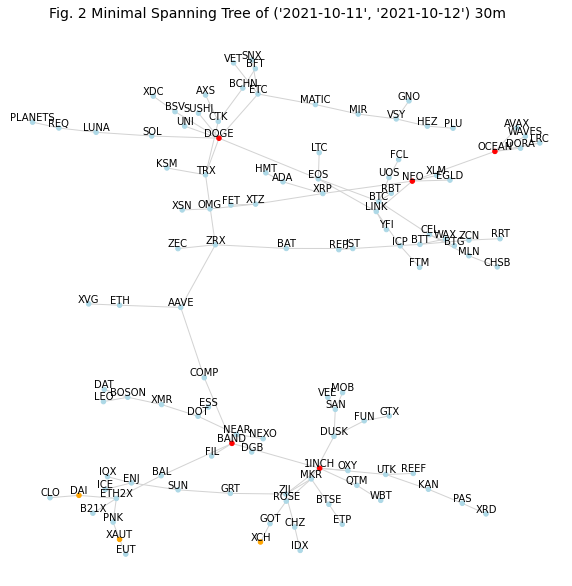

In [ ]:
MST_plot(M1, f'{time_ranges[1]} 30m', 'Fig. 2 ')

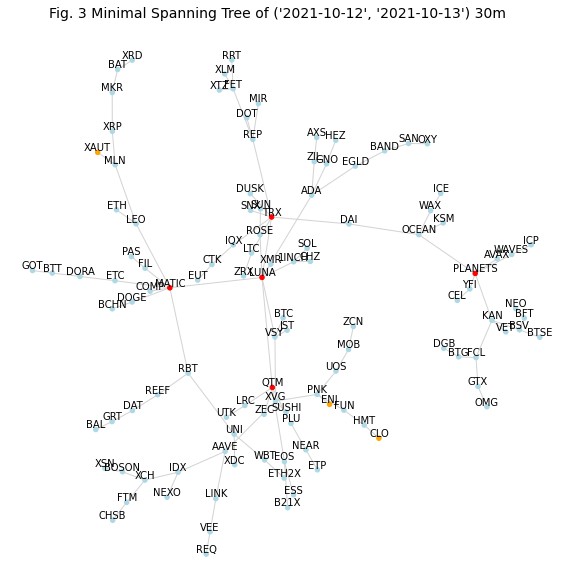

In [ ]:
MST_plot(M2, f'{time_ranges[2]} 30m', 'Fig. 3 ')

In [ ]:
# jaccard_similarity of nodes and edges in MST per day
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [ ]:
print(jaccard_similarity(M0.nodes(), M1.nodes()))
print(jaccard_similarity(M0.edges(), M1.edges()))

print(jaccard_similarity(M1.nodes(), M2.nodes()))
print(jaccard_similarity(M1.edges(), M2.edges()))

1.0
0.018
1.0
0.009
